### 1. 데이터셋 생성

In [9]:
import pandas as pd

In [10]:
# Matches.csv: Elo, 배당률, Form, 기본 스탯 포함된 Kaggle 원본
matches = pd.read_csv("Matches.csv")

# xG 데이터: 기존에 수집해두신 CSV 형식
xg = pd.read_csv("xg_data.csv")  # 예: date, team_h, team_a, h_xg, a_xg, xG_diff

# 날짜 전처리
matches['MatchDate'] = pd.to_datetime(matches['MatchDate'], errors='coerce')
xg['date'] = pd.to_datetime(xg['date'], errors='coerce')


C:\Users\haeun\AppData\Local\Temp\ipykernel_6976\3155053130.py:2: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  matches = pd.read_csv("Matches.csv")


In [11]:
matches['HomeTeam'] = matches['HomeTeam'].str.strip()
matches['AwayTeam'] = matches['AwayTeam'].str.strip()
xg['team_h'] = xg['team_h'].str.strip()
xg['team_a'] = xg['team_a'].str.strip()

matches['merge_key'] = matches['MatchDate'].astype(str) + '_' + matches['HomeTeam'] + '_' + matches['AwayTeam']
xg['merge_key'] = xg['date'].astype(str) + '_' + xg['team_h'] + '_' + xg['team_a']


In [12]:
merged = matches.merge(
    xg[['merge_key', 'h_xg', 'a_xg', 'xG_diff']],
    on='merge_key',
    how='left'
)

In [13]:
# 결과 레이블
def encode_result(r):
    if r == 'H':
        return 2
    elif r == 'D':
        return 1
    elif r == 'A':
        return 0
    return None

merged['result'] = merged['FTResult'].apply(encode_result)

# Elo 차이
merged['elo_diff'] = merged['HomeElo'] - merged['AwayElo']

# Form 처리 (결측값 -> 0)
for col in ['Form3Home', 'Form5Home', 'Form3Away', 'Form5Away']:
    merged[col] = merged[col].fillna(0)

# 경기 스탯 차이
merged['shots_diff'] = merged['HomeShots'] - merged['AwayShots']
merged['target_diff'] = merged['HomeTarget'] - merged['AwayTarget']
merged['fouls_diff'] = merged['HomeFouls'] - merged['AwayFouls']
merged['corners_diff'] = merged['HomeCorners'] - merged['AwayCorners']
merged['yellow_diff'] = merged['HomeYellow'] - merged['AwayYellow']
merged['red_diff'] = merged['HomeRed'] - merged['AwayRed']

# 배당률 → 확률화
merged['prob_home'] = 1 / merged['OddHome']
merged['prob_draw'] = 1 / merged['OddDraw']
merged['prob_away'] = 1 / merged['OddAway']
prob_sum = merged['prob_home'] + merged['prob_draw'] + merged['prob_away']
merged['prob_home'] /= prob_sum
merged['prob_draw'] /= prob_sum
merged['prob_away'] /= prob_sum

# 시간 피처
merged['month'] = pd.to_datetime(merged['MatchDate']).dt.month
merged['weekday'] = pd.to_datetime(merged['MatchDate']).dt.weekday

# xG 관련 추가 피처
merged['xg_margin'] = merged['h_xg'] - merged['a_xg']
merged['xg_ratio'] = merged['h_xg'] / (merged['a_xg'] + 1e-6)  # ZeroDivision 방지


In [15]:
cols = [
    'HomeElo', 'AwayElo', 'elo_diff',
    'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away',
    'shots_diff', 'target_diff', 'fouls_diff', 'corners_diff',
    'yellow_diff', 'red_diff',
    'prob_home', 'prob_draw', 'prob_away',
    'h_xg', 'a_xg', 'xG_diff', 'xg_margin', 'xg_ratio',
    'month', 'weekday', 'result'
]

final_df = merged[cols].dropna(subset=['result'])  # 결과 없는 경기 제외

print("✅ 통합 데이터셋 shape:", final_df.shape)
final_df.head()

✅ 통합 데이터셋 shape: (230554, 24)


,HomeElo,AwayElo,elo_diff,Form3Home,Form5Home,Form3Away,Form5Away,shots_diff,target_diff,fouls_diff,...,prob_draw,prob_away,h_xg,a_xg,xG_diff,xg_margin,xg_ratio,month,weekday,result
0,1686.34,1586.57,99.77,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.265432,0.203704,NaN,NaN,NaN,NaN,NaN,7,4,2.0
1,1714.89,1642.51,72.38,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.258790,0.191280,NaN,NaN,NaN,NaN,NaN,7,4,2.0
2,1465.08,1633.80,-168.72,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,4,0.0
3,1635.58,1624.22,11.36,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.264038,0.223417,NaN,NaN,NaN,NaN,NaN,7,5,0.0
4,1734.34,1673.11,61.23,0.0,0.0,0.0,0.0,NaN,NaN,NaN,...,0.265432,0.203704,NaN,NaN,NaN,NaN,NaN,7,5,1.0


In [16]:
final_df.to_csv("merged_dataset.csv", index=False)

---

In [23]:
import pandas as pd

# 1. 원본 데이터 불러오기 --------------------------------------------------

# Matches.csv (Kaggle 제공 데이터)
matches = pd.read_csv("Matches.csv")

# xG 데이터 (예: understat 등에서 수집한 경기당 xG 기록)
xg = pd.read_csv("xg_data.csv")

# 날짜 처리
matches['MatchDate'] = pd.to_datetime(matches['MatchDate'], errors='coerce').dt.date
xg['date'] = pd.to_datetime(xg['date'], errors='coerce').dt.date

# 공백 제거 (팀 이름)
matches['HomeTeam'] = matches['HomeTeam'].str.strip()
matches['AwayTeam'] = matches['AwayTeam'].str.strip()
xg['team_h'] = xg['team_h'].str.strip()
xg['team_a'] = xg['team_a'].str.strip()

# 2. 병합 키 생성 ---------------------------------------------------------

matches['merge_key'] = matches['MatchDate'].astype(str) + '_' + matches['HomeTeam'] + '_' + matches['AwayTeam']
xg['merge_key'] = xg['date'].astype(str) + '_' + xg['team_h'] + '_' + xg['team_a']

# 3. xG 데이터 병합 -------------------------------------------------------

merged = matches.merge(
    xg[['merge_key', 'h_xg', 'a_xg']],  # 또는 xG_diff 포함 시 'xG_diff'
    on='merge_key',
    how='left'
)

# 4. 예측용 피처 정리 -----------------------------------------------------

# 결과 라벨 인코딩 (FTResult: H/ D / A → 2 / 1 / 0)
def encode_result(r):
    if r == 'H':
        return 2
    elif r == 'D':
        return 1
    elif r == 'A':
        return 0
    return None

merged['result'] = merged['FTResult'].apply(encode_result)

# Elo 차이
merged['elo_diff'] = merged['HomeElo'] - merged['AwayElo']

# 배당률을 확률로 환산
merged['prob_home'] = 1 / merged['OddHome']
merged['prob_draw'] = 1 / merged['OddDraw']
merged['prob_away'] = 1 / merged['OddAway']
prob_sum = merged['prob_home'] + merged['prob_draw'] + merged['prob_away']
merged['prob_home'] /= prob_sum
merged['prob_draw'] /= prob_sum
merged['prob_away'] /= prob_sum

# 날짜 기반 피처
merged['month'] = pd.to_datetime(merged['MatchDate']).dt.month
merged['weekday'] = pd.to_datetime(merged['MatchDate']).dt.weekday

# xG 관련 추가 피처
merged['xG_diff'] = merged['h_xg'] - merged['a_xg']
merged['xg_margin'] = merged['xG_diff']  # 같은 값
merged['xg_ratio'] = merged['h_xg'] / (merged['a_xg'] + 1e-6)

# 5. 필요한 컬럼만 추출 ---------------------------------------------------

selected_cols = [
    'MatchDate', 'HomeTeam', 'AwayTeam',
    'HomeElo', 'AwayElo', 'elo_diff',
    'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away',
    'prob_home', 'prob_draw', 'prob_away',
    'h_xg', 'a_xg', 'xG_diff', 'xg_margin', 'xg_ratio',
    'month', 'weekday', 'result'
]

# 존재하는 컬럼만 선택
final_cols = [col for col in selected_cols if col in merged.columns]
final_df = merged[final_cols].copy()

# 6. 저장 ------------------------------------------------------------------

final_df.to_csv("merged_dataset.csv", index=False)
print("✅ 통합 완료: merged_dataset.csv 생성됨")


C:\Users\haeun\AppData\Local\Temp\ipykernel_6976\1126825244.py:6: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  matches = pd.read_csv("Matches.csv")


✅ 통합 완료: merged_dataset.csv 생성됨


In [24]:
import pandas as pd

# 1. 데이터 로딩
df = pd.read_csv("merged_dataset.csv")
df['MatchDate'] = pd.to_datetime(df['MatchDate'])

# 2. 홈/원정 경기 데이터 결합
home = df[['MatchDate', 'HomeTeam', 'h_xg', 'HomeElo']].copy()
home.columns = ['date', 'team', 'xg', 'elo']

away = df[['MatchDate', 'AwayTeam', 'a_xg', 'AwayElo']].copy()
away.columns = ['date', 'team', 'xg', 'elo']

team_games = pd.concat([home, away], axis=0).sort_values(['team', 'date']).reset_index(drop=True)

# 3. 롤링 피처 계산
team_games['rolling_xg_5'] = team_games.groupby('team')['xg'].transform(lambda x: x.shift().rolling(5, min_periods=1).mean())
team_games['elo_change'] = team_games.groupby('team')['elo'].transform(lambda x: x.diff())

# 4. 원본 df에 매핑 (홈팀)
df = df.merge(
    team_games[['team', 'date', 'rolling_xg_5', 'elo_change']],
    how='left',
    left_on=['HomeTeam', 'MatchDate'],
    right_on=['team', 'date']
)
df = df.rename(columns={
    'rolling_xg_5': 'rolling_xg_home_5',
    'elo_change': 'elo_change_home'
})
df = df.drop(columns=['team', 'date'])

# 5. 원본 df에 매핑 (원정팀)
df = df.merge(
    team_games[['team', 'date', 'rolling_xg_5', 'elo_change']],
    how='left',
    left_on=['AwayTeam', 'MatchDate'],
    right_on=['team', 'date']
)
df = df.rename(columns={
    'rolling_xg_5': 'rolling_xg_away_5',
    'elo_change': 'elo_change_away'
})
df = df.drop(columns=['team', 'date'])

# 6. 결과 확인
print(df[['HomeTeam', 'AwayTeam', 'MatchDate', 'rolling_xg_home_5', 'rolling_xg_away_5', 'elo_change_home', 'elo_change_away']].head())

# 7. 저장
df.to_csv("enhanced_dataset.csv", index=False)
print("✅ 저장 완료: enhanced_dataset.csv")


    HomeTeam    AwayTeam  MatchDate  rolling_xg_home_5  rolling_xg_away_5  \
0  Marseille      Troyes 2000-07-28                NaN                NaN   
1   Paris SG  Strasbourg 2000-07-28                NaN                NaN   
2  Wasquehal       Nancy 2000-07-28                NaN                NaN   
3    Auxerre       Sedan 2000-07-29                NaN                NaN   
4   Bordeaux        Metz 2000-07-29                NaN                NaN   

   elo_change_home  elo_change_away  
0              NaN              NaN  
1              NaN              NaN  
2              NaN              NaN  
3              NaN              NaN  
4              NaN              NaN  
✅ 저장 완료: enhanced_dataset.csv


### 2. 모델 학습

In [ ]:
from sklearn.model_selection import train_test_split

df = pd.read_csv("merged_dataset.csv")

# 피처 선택
features = [col for col in df.columns if col not in ['result']]  # 결과값 제외
X = df[features]
y = df['result']  # 0: 패, 1: 무, 2: 승

# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [37]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'  # 클래스 불균형 대응
)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


ValueError: could not convert string to float: '2021-02-06'

In [19]:
print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred, digits=3))
print("\n🧱 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

🎯 Accuracy: 0.5097265294615168

📋 Classification Report:
               precision    recall  f1-score   support

         0.0      0.498     0.559     0.527     13312
         1.0      0.325     0.334     0.329     12224
         2.0      0.644     0.582     0.612     20575

    accuracy                          0.510     46111
   macro avg      0.489     0.492     0.489     46111
weighted avg      0.517     0.510     0.512     46111


🧱 Confusion Matrix:
 [[ 7445  3392  2475]
 [ 4004  4081  4139]
 [ 3500  5097 11978]]


C:\Users\haeun\AppData\Local\Temp\ipykernel_6976\3400428787.py:14: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\haeun\Desktop\AI-Football-Manager\.venv\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


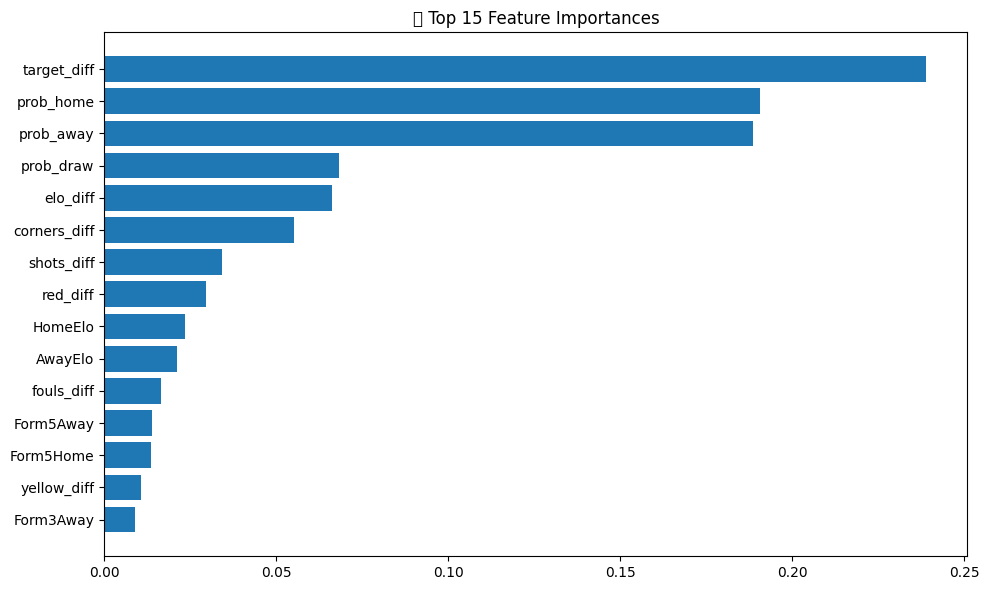

In [20]:
import matplotlib.pyplot as plt

importances = model.feature_importances_
feature_names = X.columns

# 상위 15개만 시각화
top_indices = importances.argsort()[-15:][::-1]

plt.figure(figsize=(10, 6))
plt.barh(range(15), importances[top_indices])
plt.yticks(range(15), feature_names[top_indices])
plt.title("📌 Top 15 Feature Importances")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


---

In [21]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

# 데이터 불러오기
df = pd.read_csv("merged_dataset.csv")
X = df.drop(columns=['result'])
y = df['result']

# 학습/검증 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# LightGBM 모델 설정
model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    max_depth=10,
    learning_rate=0.05,
    n_estimators=500,
    class_weight='balanced',
    random_state=42
)

# 학습
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1821
[LightGBM] [Info] Number of data points in the train set: 184443, number of used features: 18
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
🎯 Accuracy: 0.513803647719633
              precision    recall  f1-score   support

         0.0      0.507     0.557     0.531     13312
         1.0      0.329     0.353     0.340     12224
         2.0      0.651     0.582     0.614     20575

    accuracy                          0.514     46111
   macro avg      0.496     0.497     0.495     46111
weighted avg      0.524     0.514     0.518     46111



---

In [ ]:
import pandas as pd

# 1. 원본 데이터 불러오기 --------------------------------------------------

# Matches.csv (Kaggle 제공 데이터)
matches = pd.read_csv("Matches.csv")

# xG 데이터 (예: understat 등에서 수집한 경기당 xG 기록)
xg = pd.read_csv("xg_data.csv")

# 날짜 처리
matches['MatchDate'] = pd.to_datetime(matches['MatchDate'], errors='coerce').dt.date
xg['date'] = pd.to_datetime(xg['date'], errors='coerce').dt.date

# 공백 제거 (팀 이름)
matches['HomeTeam'] = matches['HomeTeam'].str.strip()
matches['AwayTeam'] = matches['AwayTeam'].str.strip()
xg['team_h'] = xg['team_h'].str.strip()
xg['team_a'] = xg['team_a'].str.strip()

# 2. 병합 키 생성 ---------------------------------------------------------

matches['merge_key'] = matches['MatchDate'].astype(str) + '_' + matches['HomeTeam'] + '_' + matches['AwayTeam']
xg['merge_key'] = xg['date'].astype(str) + '_' + xg['team_h'] + '_' + xg['team_a']

# 3. xG 데이터 병합 -------------------------------------------------------

merged = matches.merge(
    xg[['merge_key', 'h_xg', 'a_xg']],  # 또는 xG_diff 포함 시 'xG_diff'
    on='merge_key',
    how='left'
)

# 4. 예측용 피처 정리 -----------------------------------------------------

# 결과 라벨 인코딩 (FTResult: H/ D / A → 2 / 1 / 0)
def encode_result(r):
    if r == 'H':
        return 2
    elif r == 'D':
        return 1
    elif r == 'A':
        return 0
    return None

merged['result'] = merged['FTResult'].apply(encode_result)

# Elo 차이
merged['elo_diff'] = merged['HomeElo'] - merged['AwayElo']

# 배당률을 확률로 환산
merged['prob_home'] = 1 / merged['OddHome']
merged['prob_draw'] = 1 / merged['OddDraw']
merged['prob_away'] = 1 / merged['OddAway']
prob_sum = merged['prob_home'] + merged['prob_draw'] + merged['prob_away']
merged['prob_home'] /= prob_sum
merged['prob_draw'] /= prob_sum
merged['prob_away'] /= prob_sum

# 날짜 기반 피처
merged['month'] = pd.to_datetime(merged['MatchDate']).dt.month
merged['weekday'] = pd.to_datetime(merged['MatchDate']).dt.weekday

# xG 관련 추가 피처
merged['xG_diff'] = merged['h_xg'] - merged['a_xg']
merged['xg_margin'] = merged['xG_diff']  # 같은 값
merged['xg_ratio'] = merged['h_xg'] / (merged['a_xg'] + 1e-6)

# 5. 필요한 컬럼만 추출 ---------------------------------------------------

selected_cols = [
    'MatchDate', 'HomeTeam', 'AwayTeam',
    'HomeElo', 'AwayElo', 'elo_diff',
    'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away',
    'prob_home', 'prob_draw', 'prob_away',
    'h_xg', 'a_xg', 'xG_diff', 'xg_margin', 'xg_ratio',
    'month', 'weekday', 'result'
]

# 존재하는 컬럼만 선택
final_cols = [col for col in selected_cols if col in merged.columns]
final_df = merged[final_cols].copy()


# 6. 저장 ------------------------------------------------------------------

final_df.to_csv("merged_dataset.csv", index=False)
print("✅ 통합 완료: merged_dataset.csv 생성됨")


In [39]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1. 데이터 불러오기 -------------------------------------------------------

df = pd.read_csv("enhanced_dataset.csv")

# NaN 결과 제거
df = df.dropna(subset=['result'])

# 수치형 피처만 선택 (혹은 불필요한 object 컬럼 제거)
X = df.drop(columns=['result', 'MatchDate', 'HomeTeam', 'AwayTeam'])

essential_cols = [
    'HomeElo', 'AwayElo', 'elo_diff',
    'Form3Home', 'Form5Home', 'Form3Away', 'Form5Away',
    'prob_home', 'prob_draw', 'prob_away',
    'xG_diff', 'xg_ratio',  # <- 성능에 가장 많이 기여했던 피처
    'month', 'weekday'
]

X = df[essential_cols]
# y = df['result']

y = df['result']

# 2. 학습/검증 데이터 분할 -------------------------------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. LightGBM 모델 정의 및 학습 --------------------------------------------

model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    max_depth=10,
    learning_rate=0.05,
    n_estimators=500,
    class_weight='balanced',
    random_state=42
)

model.fit(X_train, y_train)

# 4. 예측 및 성능 평가 ------------------------------------------------------

y_pred = model.predict(X_test)

print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred, digits=3))
print("\n🧱 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1959
[LightGBM] [Info] Number of data points in the train set: 184443, number of used features: 14
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

In [40]:
import pandas as pd

# 데이터 불러오기
df = pd.read_csv("enhanced_dataset.csv")

# 결측 제거
df = df.dropna(subset=['result'])

# 홈팀 승리 여부 (이진 타깃 생성)
df['is_home_win'] = (df['result'] == 2).astype(int)

# 불필요한 문자열 컬럼 제거
X = df.drop(columns=['result', 'MatchDate', 'HomeTeam', 'AwayTeam', 'is_home_win'])
y = df['is_home_win']


In [41]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 모델 정의
model = lgb.LGBMClassifier(
    objective='binary',
    learning_rate=0.05,
    n_estimators=500,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)

# 학습
model.fit(X_train, y_train)

# 예측
y_pred = model.predict(X_test)

# 평가
print("🎯 Accuracy:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred, digits=3))
print("\n🧱 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


[LightGBM] [Info] Number of positive: 82298, number of negative: 102145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006516 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3486
[LightGBM] [Info] Number of data points in the train set: 184443, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

In [42]:
import optuna
import lightgbm as lgb
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 📦 데이터 준비
df = pd.read_csv("enhanced_dataset.csv")
df = df.dropna(subset=['result'])
df['is_home_win'] = (df['result'] == 2).astype(int)
X = df.drop(columns=['result', 'MatchDate', 'HomeTeam', 'AwayTeam', 'is_home_win'])
y = df['is_home_win']

# 📊 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 🎯 Optuna 최적화 함수 정의
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_error',
        'boosting_type': 'gbdt',
        'verbosity': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 4, 16),
        'num_leaves': trial.suggest_int('num_leaves', 8, 256),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 2.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
        'random_state': 42
    }
    
    model = lgb.LGBMClassifier(**params, n_estimators=500)
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    accuracy = accuracy_score(y_val, preds)
    return 1.0 - accuracy  # Optuna는 값을 최소화하므로 1 - acc 사용

# 🧪 최적화 실행
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)  # 30회 반복 (필요 시 더 늘릴 수 있음)

# ✅ 최적 파라미터 출력
print("Best accuracy:", 1 - study.best_value)
print("Best params:", study.best_params)


c:\Users\haeun\Desktop\AI-Football-Manager\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-07-02 15:48:44,788] A new study created in memory with name: no-name-4cfe8dd4-956f-4da5-9f79-9aa09b9d376e
[I 2025-07-02 15:48:50,191] Trial 0 finished with value: 0.3777406692546247 and parameters: {'learning_rate': 0.1438248244875804, 'max_depth': 11, 'num_leaves': 93, 'min_child_samples': 24, 'subsample': 0.8305502540527945, 'colsample_bytree': 0.6318071844860466, 'reg_alpha': 0.42523555322108253, 'reg_lambda': 0.6936611095968519}. Best is trial 0 with value: 0.3777406692546247.
[I 2025-07-02 15:49:00,187] Trial 1 finished with value: 0.37717681247424695 and parameters: {'learning_rate': 0.08995444350293148, 'max_depth': 15, 'num_leaves': 230, 'min_child_samples': 59, 'subsample': 0.6974083140646609, 'colsamp

Best accuracy: 0.6327774283793455
Best params: {'learning_rate': 0.012587582340310363, 'max_depth': 4, 'num_leaves': 172, 'min_child_samples': 40, 'subsample': 0.9700719452188175, 'colsample_bytree': 0.8490552601335883, 'reg_alpha': 1.952069295331694, 'reg_lambda': 0.66681019000377}


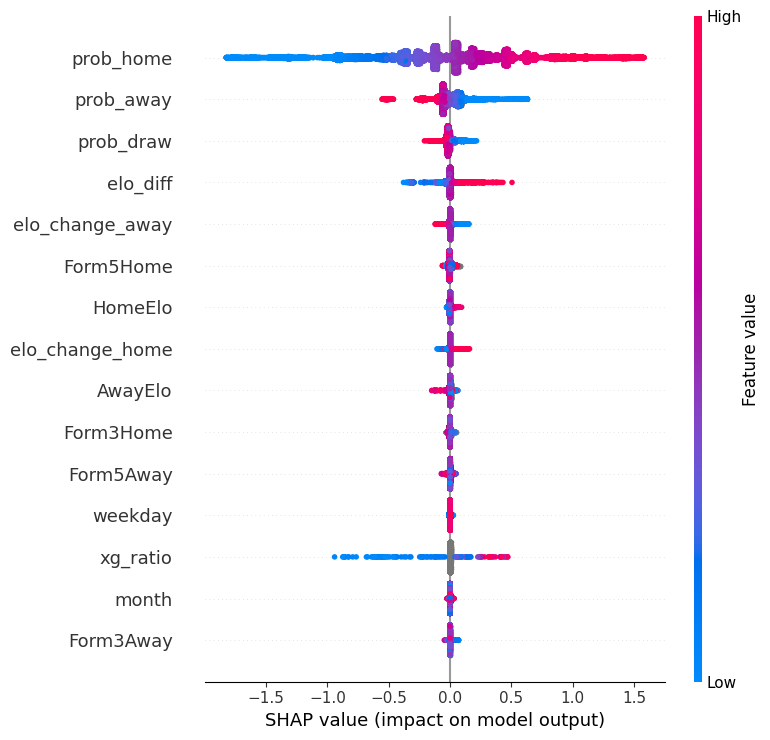

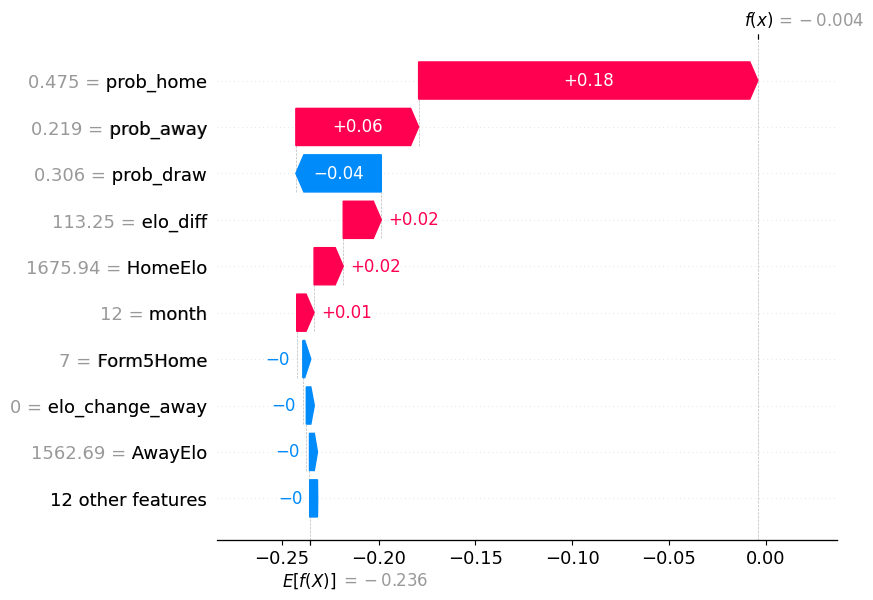

In [44]:
import shap
import matplotlib.pyplot as plt

# 모델 학습 (Optuna에서 나온 best_params 사용)
best_params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'n_estimators': 500,
    'random_state': 42,
    **study.best_params
}

model = lgb.LGBMClassifier(**best_params)
model.fit(X_train, y_train)

# SHAP 분석
explainer = shap.Explainer(model)
shap_values = explainer(X_test)

# 전체 피처 중요도 (요약 plot)
shap.summary_plot(shap_values, X_test, max_display=15)

# 개별 샘플 하나 보기 (예: 첫 번째 경기)
shap.plots.waterfall(shap_values[0])
